<a href="https://colab.research.google.com/github/tsato-code/colab_notebooks/blob/main/zero2_chap01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
def load_data(seed=1984):
    np.random.seed(seed)
    N = 100  # クラスごとのサンプル数
    DIM = 2  # データの要素数
    CLS_NUM = 3  # クラス数

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)

    for j in range(CLS_NUM):
        for i in range(N):#N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

x (300, 2)
t (300, 3)


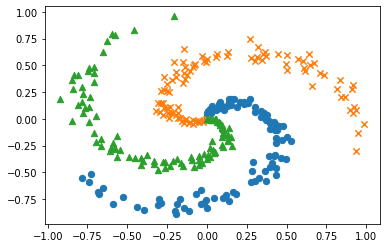

In [3]:
x, t = load_data()
print('x', x.shape)
print('t', t.shape)

N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [5]:
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
    
    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out
    
    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)
        
        loss = cross_entropy_error(self.y, self.t)
        return loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size
        
        return dx

In [6]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.random.randn(O)

        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

In [7]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

In [8]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.currenct_epoch = 0
    
    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            idx = np.random.permutation(data_size)
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)
                if max_grad is not None:
                    clip_grads(grads, max_grads)
                optimizer.update(model.params, model.grads)
                total_loss += loss
                loss_count += 1

                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print(f'| epoch {epoch+1} | iter {iters+1} / {max_iters} | time {elapsed_time:.1}[s] | loss {avg_loss:.2f}')
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0
            
            self.currenct_epoch += 1
    
    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel(f'iterations (x{str(self.eval_interval)})')
        plt.ylabel('loss')
        plt.show()


def remove_duplicate(params, grads):
    params, grads = params, grads
    
    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                if params[i] is params[j]:
                    grads[i] += grads[j]
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                    params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break
        
        if not find_flg: break
    
    return params, grads


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

| epoch 1 | iter 1 / 10 | time 0.0006[s] | loss 1.41
| epoch 2 | iter 1 / 10 | time 0.004[s] | loss 1.18
| epoch 3 | iter 1 / 10 | time 0.007[s] | loss 1.15
| epoch 4 | iter 1 / 10 | time 0.009[s] | loss 1.15
| epoch 5 | iter 1 / 10 | time 0.01[s] | loss 1.11
| epoch 6 | iter 1 / 10 | time 0.01[s] | loss 1.14
| epoch 7 | iter 1 / 10 | time 0.01[s] | loss 1.11
| epoch 8 | iter 1 / 10 | time 0.02[s] | loss 1.10
| epoch 9 | iter 1 / 10 | time 0.02[s] | loss 1.06
| epoch 10 | iter 1 / 10 | time 0.02[s] | loss 1.09
| epoch 11 | iter 1 / 10 | time 0.02[s] | loss 1.05
| epoch 12 | iter 1 / 10 | time 0.02[s] | loss 1.04
| epoch 13 | iter 1 / 10 | time 0.02[s] | loss 0.99
| epoch 14 | iter 1 / 10 | time 0.03[s] | loss 0.97
| epoch 15 | iter 1 / 10 | time 0.03[s] | loss 0.95
| epoch 16 | iter 1 / 10 | time 0.03[s] | loss 0.97
| epoch 17 | iter 1 / 10 | time 0.03[s] | loss 0.96
| epoch 18 | iter 1 / 10 | time 0.03[s] | loss 0.93
| epoch 19 | iter 1 / 10 | time 0.03[s] | loss 0.92
| epoch 20 | ite

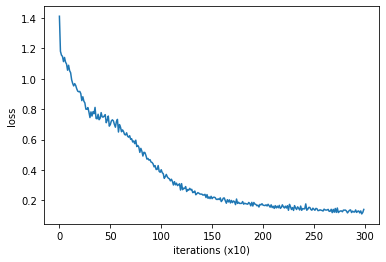

In [9]:
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)
trainer = Trainer(model, optimizer)
trainer.fit(x, t, max_epoch, batch_size, eval_interval=10)
trainer.plot()